In [1]:
# Uncomment and run the commands below if imports fail
# !conda install numpy pytorch torchvision cpuonly -c pytorch -y
# !pip install matplotlib --upgrade --quiet
!pip install jovian --upgrade --quiet

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [78]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import jovian
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split

In [38]:
project_name='02-wine-logistic-regression' # will be used by jovian.commit

In [8]:
# Import the dataset into pandas
filename = '../input/red-wine-quality-cortez-et-al-2009/winequality-red.csv'
dataframe = pd.read_csv(filename)
dataframe.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Explore the data

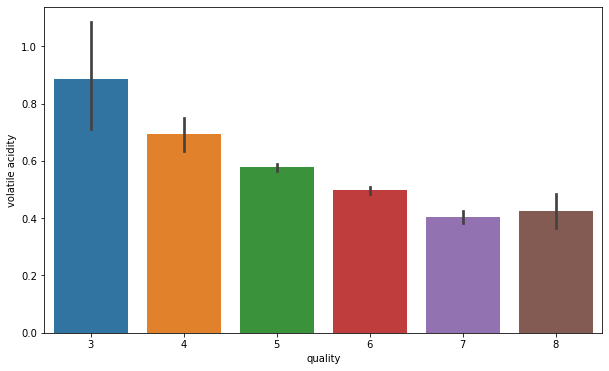

In [80]:
#Here we see that its quite a downing trend in the volatile acidity as we go higher the quality 
fig = plt.figure(figsize = (10,6))
sns.barplot(x = 'quality', y = 'volatile acidity', data = dataframe)

Train the model using linear regression

In [9]:
input_cols = dataframe.columns.values[:-1]
output_cols = dataframe.columns.values[-1]
print(input_cols)
print(output_cols)

['fixed acidity' 'volatile acidity' 'citric acid' 'residual sugar'
 'chlorides' 'free sulfur dioxide' 'total sulfur dioxide' 'density' 'pH'
 'sulphates' 'alcohol']
quality


In [43]:
inputs_array = dataframe[input_cols].to_numpy()
targets_array = dataframe[output_cols].to_numpy()
# torch.from_numpy shares memory. We can use the default torch.float64 type
inputs = torch.from_numpy(inputs_array).type(torch.FloatTensor) 
targets = torch.from_numpy(targets_array)
print(inputs.dtype, targets.dtype)
dataset = TensorDataset(inputs, targets)
print(len(dataset))

torch.float32 torch.int64
1599


In [44]:
val_percent = 0.1 #  [10%]
num_rows = dataframe.shape[0]
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size

# Use the random_split function to split dataset into 2 parts of the desired length
train_ds, val_ds = random_split(dataset, [train_size, val_size]) 
print(len(train_ds), len(val_ds))

# Create DataLoaders
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

1440 159


In [81]:
# Hyperparmeters
batch_size = 128
learning_rate = 0.001

# Other constants
input_size = 11  # columns
num_classes = 6  # number of target classes [3-8]
jovian.reset()
jovian.log_hyperparams(batch_size=batch_size, learning_rate=learning_rate)

[jovian] Hyperparams logged.


In [ ]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..


In [72]:
class WineQualityModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)  # fill this (hint: use input_size & output_size defined above)
        
    def forward(self, xb):
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        inputs, labels = batch 
        # Generate predictions
        out = self(inputs)          
        # Calcuate loss
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        inputs, labels = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 100 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch+1, result['val_loss'], result['val_acc']))

In [73]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

In [77]:
model = WineQualityModel()
history = fit(2000, 1e-5, model, train_loader, val_loader)

Epoch [100], val_loss: 1.7262, val_acc: 0.4958
Epoch [200], val_loss: 1.6717, val_acc: 0.4997
Epoch [300], val_loss: 1.6274, val_acc: 0.5159
Epoch [400], val_loss: 1.5933, val_acc: 0.5159
Epoch [500], val_loss: 1.5667, val_acc: 0.5120
Epoch [600], val_loss: 1.5482, val_acc: 0.5120
Epoch [700], val_loss: 1.5321, val_acc: 0.5120
Epoch [800], val_loss: 1.5195, val_acc: 0.5159
Epoch [900], val_loss: 1.5100, val_acc: 0.5159
Epoch [1000], val_loss: 1.5000, val_acc: 0.5276
Epoch [1100], val_loss: 1.4923, val_acc: 0.5237
Epoch [1200], val_loss: 1.4854, val_acc: 0.5237
Epoch [1300], val_loss: 1.4785, val_acc: 0.5276
Epoch [1400], val_loss: 1.4725, val_acc: 0.5315
Epoch [1500], val_loss: 1.4683, val_acc: 0.5276
Epoch [1600], val_loss: 1.4624, val_acc: 0.5276
Epoch [1700], val_loss: 1.4578, val_acc: 0.5276
Epoch [1800], val_loss: 1.4521, val_acc: 0.5276
Epoch [1900], val_loss: 1.4470, val_acc: 0.5276
Epoch [2000], val_loss: 1.4441, val_acc: 0.5276


In [ ]:
accuracies = [r['val_acc'] for r in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');